In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('../lecture 2/names.txt').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [5]:
#Build the vocab of chars and mappings to/from ints
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [7]:
#build the dataset
block_size = 3 #context length

def build_dataset(words):
    X,Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] #crop and append
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)

    print(X.shape, Y.shape)
    return X,Y
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev,Ydev = build_dataset(words[n1:n2])
Xte,Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [27]:
#MPL revisited
n_embd = 10 #dimensionality of char embedding vects
n_hidden = 200 #number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [28]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    #minibatch construct
    ix = torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
    Xb,Yb = Xtr[ix], Ytr[ix] #batch X,Y
    #Forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0],-1) #concatenate the vectors 
    hpreact = embcat @ W1 + b1 #hidden layer preactivation
    h = torch.tanh(hpreact) #hidden layer
    logits = h @ W2 + b2 #output layer 
    loss = F.cross_entropy(logits,Yb)

    #Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update 
    lr = 0.1 if i < 100000 else 0.01 #step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    #track stats 
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3221
  10000/ 200000: 2.1900
  20000/ 200000: 2.4196
  30000/ 200000: 2.6067
  40000/ 200000: 2.0601
  50000/ 200000: 2.4988
  60000/ 200000: 2.3902
  70000/ 200000: 2.1344
  80000/ 200000: 2.3369
  90000/ 200000: 2.1299
 100000/ 200000: 1.8329
 110000/ 200000: 2.2053
 120000/ 200000: 1.8540
 130000/ 200000: 2.4566
 140000/ 200000: 2.1879
 150000/ 200000: 2.1118
 160000/ 200000: 1.8956
 170000/ 200000: 1.8645
 180000/ 200000: 2.0326
 190000/ 200000: 1.8417


In [24]:
logits[0]

tensor([-0.0249,  0.3523, -0.1267,  0.0541,  0.1662, -0.1171, -0.0140,  0.0124,
         0.0921,  0.1135,  0.1362, -0.0925,  0.0444, -0.2459, -0.0971,  0.0125,
        -0.0957, -0.1376, -0.2329, -0.0137,  0.2452,  0.1616,  0.1665, -0.1094,
        -0.2154,  0.0725,  0.1141], grad_fn=<SelectBackward0>)

In [ ]:
#we can see the logits are fucking massive. reduce bias to initialise at 0, and reduce W2 by multiplying by a number so it doesn't blow up so hard
#why not reduce W2 to 0? we went with 0.01 for symmetry breaking and introduce some entropy to our intial W2s

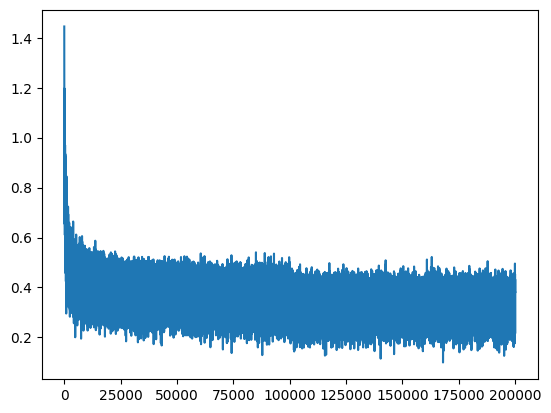

In [12]:
plt.plot(lossi)

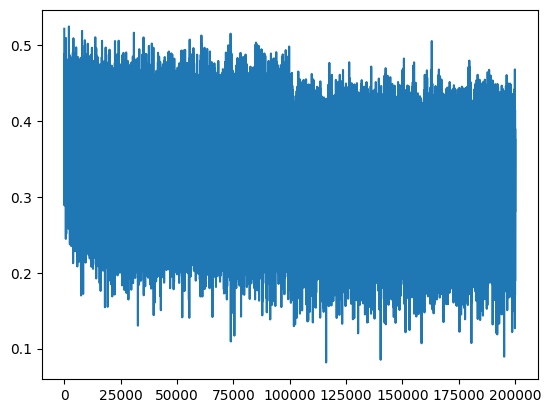

In [29]:
plt.plot(lossi) #now we don't have a hockey stick type loss. we're just seeing "difficult gains"

In [13]:
-torch.tensor(1/27.0).log()

tensor(3.2958)

In [14]:
#4 dimensional example of the initilisation problem, we're seeing 27 as an initial NLL but it should be like 3.3 

logits = torch.tensor([0.0,0.0,0.0,0.0])
probs = torch.softmax(logits,dim=0)
loss = -probs[2].log()
probs,loss

(tensor([0.2500, 0.2500, 0.2500, 0.2500]), tensor(1.3863))

In [30]:
#second problem. logits are now okay. we redo everything and look at H.¨
# MLP revisited
n_embd = 10 #dimensionality of char embedding vects
n_hidden = 200 #number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [31]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    #minibatch construct
    ix = torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
    Xb,Yb = Xtr[ix], Ytr[ix] #batch X,Y
    #Forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0],-1) #concatenate the vectors 
    hpreact = embcat @ W1 + b1 #hidden layer preactivation
    h = torch.tanh(hpreact) #hidden layer
    logits = h @ W2 + b2 #output layer 
    loss = F.cross_entropy(logits,Yb)

    #Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update 
    lr = 0.1 if i < 100000 else 0.01 #step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    #track stats 
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break

      0/ 200000: 3.3221


In [32]:
h #tanh is a squashing function. let's look at the histogram first

tensor([[ 0.8100, -0.8997, -0.9993,  ..., -0.9097, -1.0000,  1.0000],
        [-1.0000, -0.9571, -0.7145,  ...,  0.4898,  0.9090,  0.9937],
        [ 0.9983, -0.3340,  1.0000,  ...,  0.9443,  0.9905,  1.0000],
        ...,
        [-1.0000,  0.9604, -0.1418,  ..., -0.1266,  1.0000,  1.0000],
        [-1.0000, -0.4385, -0.8882,  ..., -0.3316,  0.9995,  1.0000],
        [-1.0000,  0.9604, -0.1418,  ..., -0.1266,  1.0000,  1.0000]],
       grad_fn=<TanhBackward0>)

In [33]:
h.shape

torch.Size([32, 200])

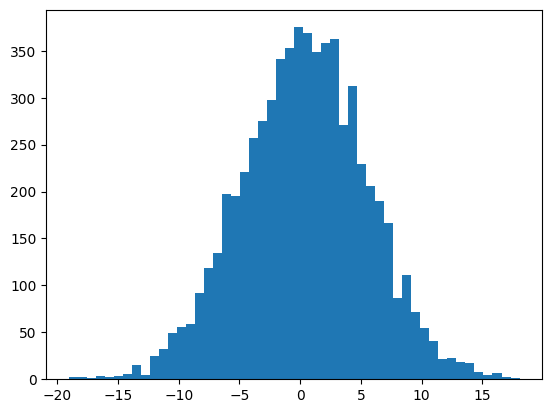

In [36]:
plt.hist(hpreact.view(-1).tolist(), 50); #inputs to our tanH. this distribution is very broad. tanH is a sq1uashing function and squashes these extreme values to 1 or -1. 

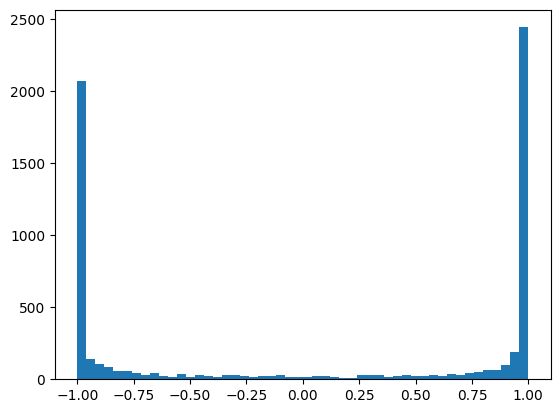

In [35]:
plt.hist(h.view(-1).tolist(), 50); #WOAHHHH most of these values are -1 or 1. tanH is very active. 

In [ ]:
#This is problematic. the backprop for tanH has a gradient of 1-t**2 * out.grad
# if our input is -1 or 1 itll be very close or actually 0. this 0 is multiplied into our out.grad and we're killing our gradient. we're vanishing a useful gradient number 
#and "killing the neuron." if t = 0 then tanH doesn't affect our gradient at all and it just passes the gradient through to the next layer of the network

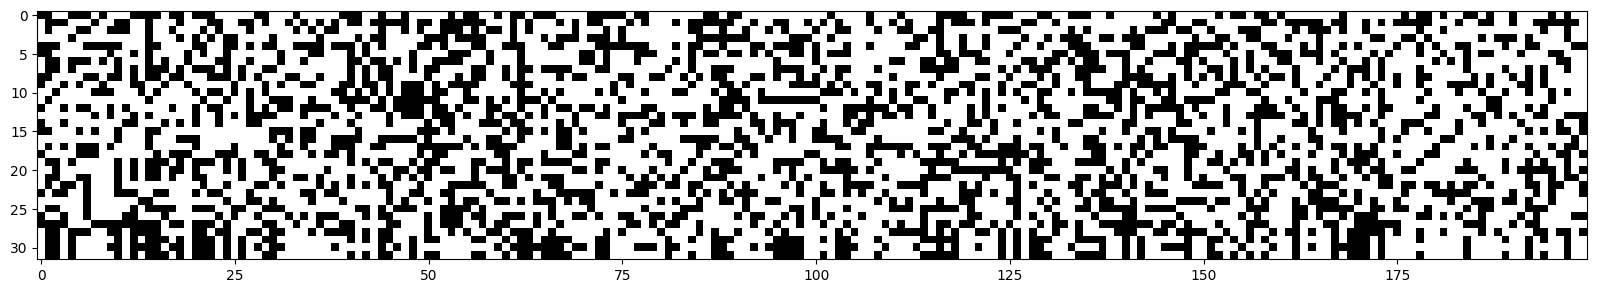

In [37]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()> 0.99, cmap = "gray", interpolation= "nearest")

In [ ]:
#this is a boolean tensor. if it's white then our h is 0.99. any fully white columns represent a dead neuron. not the case here, but something to look out for. 

#our tanh is saturated, lets fix it 

In [43]:
#second problem. logits are now okay. we redo everything and look at H.¨
# MLP revisited
n_embd = 10 #dimensionality of char embedding vects
n_hidden = 200 #number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2 #this gets multiplied into our tanh input so we make it smaller to make it not an extreme distribution and unsaturate our tanH hopefully
b1 = torch.randn(n_hidden, generator=g) * 0.01 #this gets multiplied into our tanh input so we make it smaller to make it not an extreme distribution and unsaturate our tanH hopefully
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [44]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    #minibatch construct
    ix = torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
    Xb,Yb = Xtr[ix], Ytr[ix] #batch X,Y
    #Forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0],-1) #concatenate the vectors 
    hpreact = embcat @ W1 + b1 #hidden layer preactivation
    h = torch.tanh(hpreact) #hidden layer
    logits = h @ W2 + b2 #output layer 
    loss = F.cross_entropy(logits,Yb)

    #Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update 
    lr = 0.1 if i < 100000 else 0.01 #step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    #track stats 
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break

      0/ 200000: 3.3135


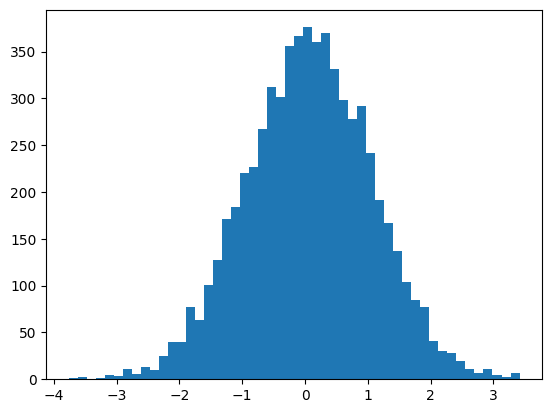

In [45]:
plt.hist(hpreact.view(-1).tolist(), 50); #inputs to our tanH. this distribution is very broad. tanH is a sq1uashing function and squashes these extreme values to 1 or -1. 

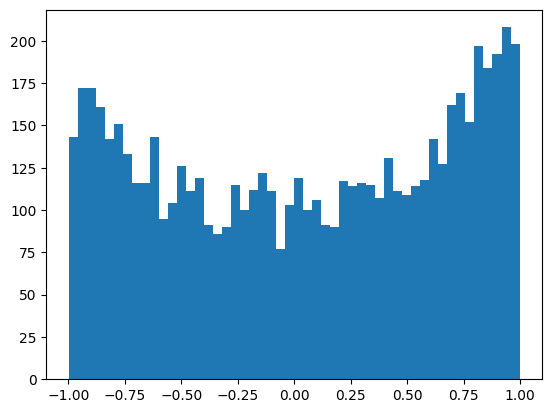

In [46]:
plt.hist(h.view(-1).tolist(), 50); #WOAHHHH most of these values are -1 or 1. tanH is very active. 

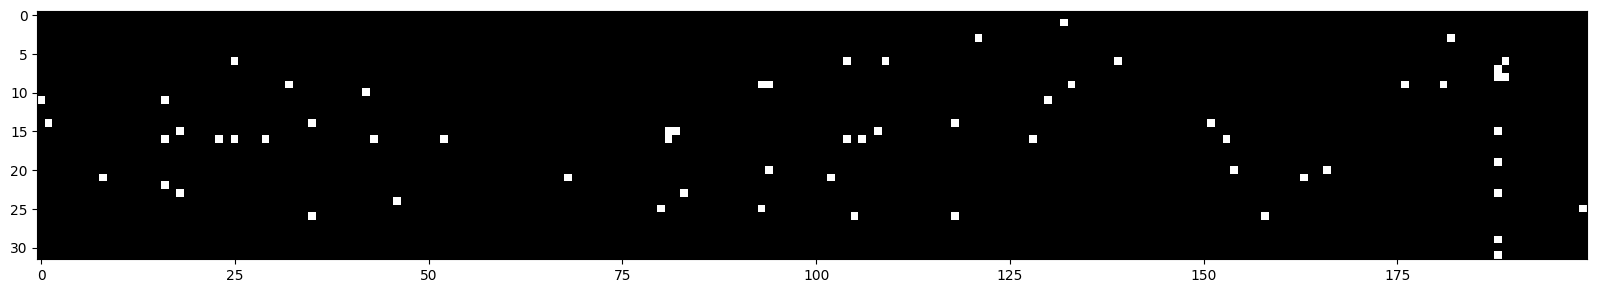

In [47]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()> 0.99, cmap = "gray", interpolation= "nearest")

In [48]:
#second problem. logits are now okay. we redo everything and look at H.¨
# MLP revisited
n_embd = 10 #dimensionality of char embedding vects
n_hidden = 200 #number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2 #this gets multiplied into our tanh input so we make it smaller to make it not an extreme distribution and unsaturate our tanH hopefully
b1 = torch.randn(n_hidden, generator=g) * 0.01 #this gets multiplied into our tanh input so we make it smaller to make it not an extreme distribution and unsaturate our tanH hopefully
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [49]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    #minibatch construct
    ix = torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
    Xb,Yb = Xtr[ix], Ytr[ix] #batch X,Y
    #Forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0],-1) #concatenate the vectors 
    hpreact = embcat @ W1 + b1 #hidden layer preactivation
    h = torch.tanh(hpreact) #hidden layer
    logits = h @ W2 + b2 #output layer 
    loss = F.cross_entropy(logits,Yb)

    #Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update 
    lr = 0.1 if i < 100000 else 0.01 #step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    #track stats 
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3135
  10000/ 200000: 2.1648
  20000/ 200000: 2.3061
  30000/ 200000: 2.4541
  40000/ 200000: 1.9787
  50000/ 200000: 2.2930
  60000/ 200000: 2.4232
  70000/ 200000: 2.0680
  80000/ 200000: 2.3095
  90000/ 200000: 2.1207
 100000/ 200000: 1.8269
 110000/ 200000: 2.2045
 120000/ 200000: 1.9797
 130000/ 200000: 2.3946
 140000/ 200000: 2.1000
 150000/ 200000: 2.1948
 160000/ 200000: 1.8619
 170000/ 200000: 1.7809
 180000/ 200000: 1.9673
 190000/ 200000: 1.8295


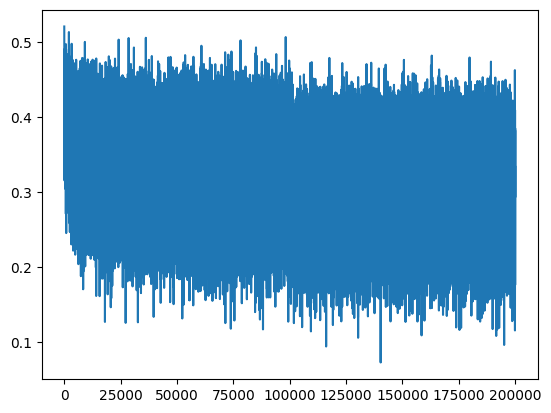

In [50]:
plt.plot(lossi)

In [51]:
@torch.no_grad() #this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        "train": (Xtr,Ytr),
        "val": (Xdev,Ydev),
        "test":(Xte,Yte)
    }[split]
    emb = C[x] #(N, block_size, n_embd)
    embcat = emb.view(emb.shape[0],-1) # concat into (N, block_size * n_embd)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @W2 + b2 #(N, vocab_size)
    loss = F.cross_entropy(logits,y)
    print(split, loss.item())

split_loss("train")
split_loss("val")

train 2.0355966091156006
val 2.102677822113037


tensor(0.0066) tensor(0.9946)
tensor(-0.0023) tensor(0.9970)


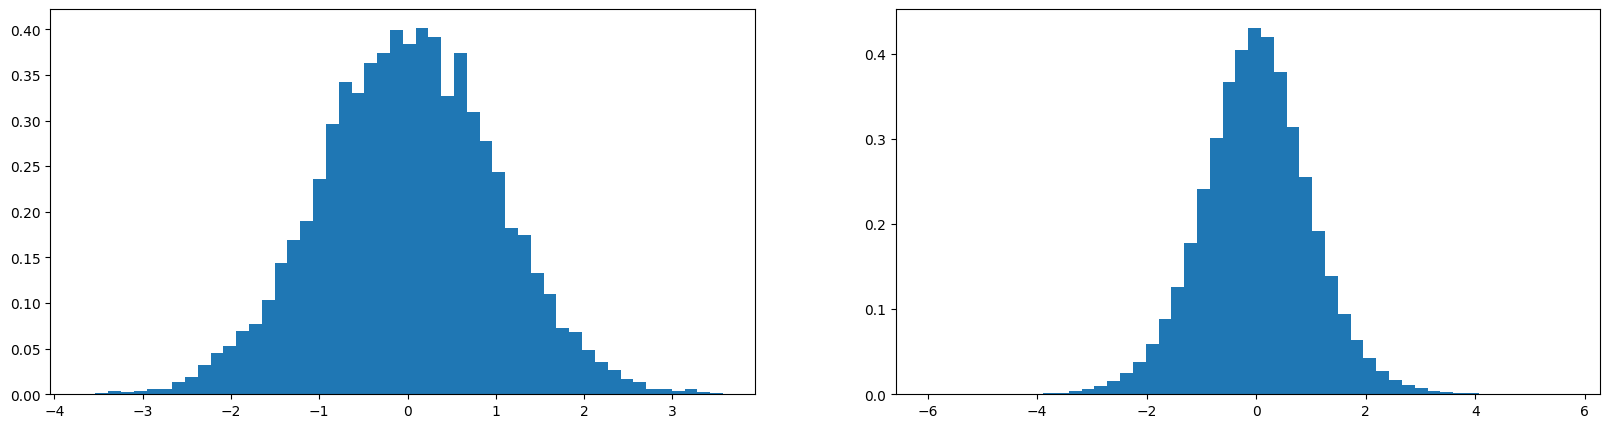

In [60]:
#these init problems are't such a problem for our small ass network but will definitely fuck up a sufficiently complex NN
#btw these scalings we did are unprincipled as fuck. there's a better way than just choosing magic numbers like 0.01 and 0.2 and whatever the fuck
#this is a motivating example
x = torch.randn(1000,10)
w = torch.randn(10,200)  / 10**0.5#we gotta multiply this bad boy by something to preserve our std of 1 for our x vector. we divide by the sqrt of the "fan in"
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(list(x.view(-1)), 50, density=True);
plt.subplot(122)
plt.hist(list(y.view(-1)), 50, density=True);

In [ ]:
#we need to add a "gain" to our scaling factor for our weights to undo the squashing effect of our tanH activation function

In [61]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * ((5/3) / (n_embd * block_size)**0.5) #KAIMING INITTTTTT GRAHHHHHHH
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 #scaling W2 down at init to prevent first iter logits from being too high
b2 = torch.randn(vocab_size,                      generator=g) * 0 #setting b2 to be 0 at initialization to prevent first iter logits from going nuts


parameters = [C, W1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11697


In [62]:
#Dame optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    #minibatch construct
    ix = torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
    Xb,Yb = Xtr[ix], Ytr[ix] #batch X,Y
    #Forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0],-1) #concatenate the vectors 
    hpreact = embcat @ W1 + b1 #hidden layer preactivation
    h = torch.tanh(hpreact) #hidden layer
    logits = h @ W2 + b2 #output layer 
    loss = F.cross_entropy(logits,Yb)

    #Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update 
    lr = 0.1 if i < 100000 else 0.01 #step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    #track stats 
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    #break


      0/ 200000: 3.3179
  10000/ 200000: 2.1928
  20000/ 200000: 2.3333
  30000/ 200000: 2.5376
  40000/ 200000: 1.9618
  50000/ 200000: 2.3344
  60000/ 200000: 2.3849
  70000/ 200000: 2.1605
  80000/ 200000: 2.3181
  90000/ 200000: 2.2200
 100000/ 200000: 1.8285
 110000/ 200000: 2.1300
 120000/ 200000: 1.9468
 130000/ 200000: 2.3329
 140000/ 200000: 2.1031
 150000/ 200000: 2.1707
 160000/ 200000: 1.7701
 170000/ 200000: 1.7840
 180000/ 200000: 1.9529
 190000/ 200000: 1.8062


In [ ]:
#we do batchnorm tommorow morning